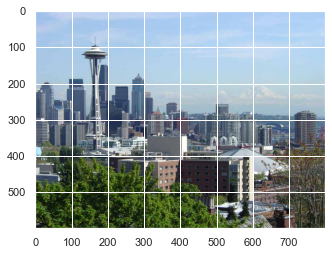

In [48]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import ndimage
from scipy import signal, misc
from scipy.signal import convolve2d
from skimage import filters
from skimage.color import rgb2yuv, rgb2hsv, rgb2gray, yuv2rgb, hsv2rgb
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import matplotlib.image as img
import seaborn as sns
from PIL import Image, ImageFilter
import imageio
sns.set()

#1 Gaussian Filter
image_1 = Image.open("Seattle.jpg")
image_1 = np.asarray(image_1)
plt.imshow(image_1)

In [49]:
#Gaussian Filter Function
sigma = 4
filter_size = 2 * int(4 * sigma + 0.5) + 1
gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
for i in range(filter_size):
    for j in range(filter_size):
        x = i - filter_size // 2
        y = j - filter_size // 2
        gaussian_filter[i, j] = 1 / (2 * np.pi * sigma ** 2) * np.exp(-(x ** 2 + y ** 2)/(2 * sigma ** 2))
print(gaussian_filter.sum())

0.9999293


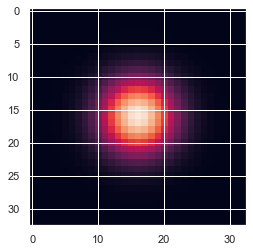

In [50]:
#Displaying Gaussian Filter
plt.imshow(gaussian_filter)

In [51]:
delta = np.zeros((filter_size, filter_size), dtype=np.float32)
delta[filter_size // 2, filter_size // 2] = 1
gaussian_filter_skimage = filters.gaussian(delta, sigma=sigma)
sobel_filter_skimage = filters.sobel(delta)
print(gaussian_filter_skimage.sum())
print(sobel_filter_skimage.sum())

1.0
2.4142137


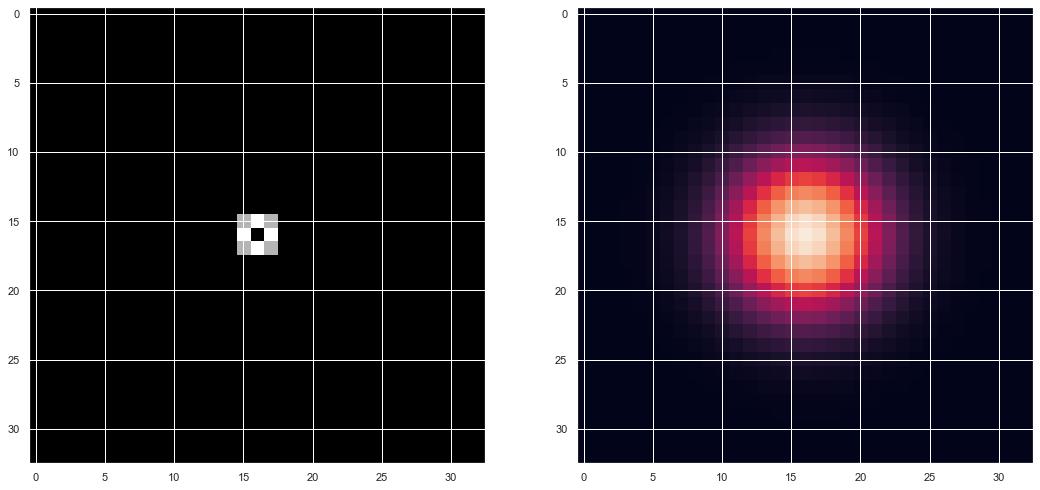

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
ax1.imshow(sobel_filter_skimage, cmap='gray')
ax2.imshow(gaussian_filter_skimage)
plt.show()

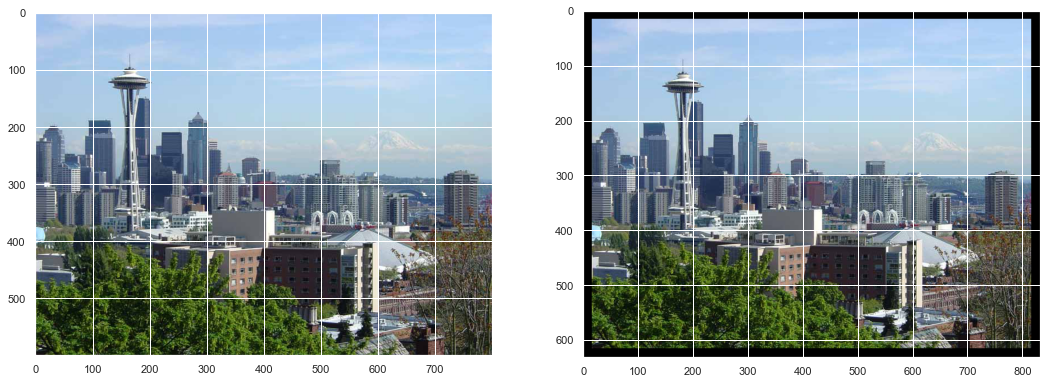

In [53]:
im_padded = np.pad(image_1, pad_width=((filter_size // 2, filter_size // 2), (filter_size // 2, filter_size // 2), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
fig, (ax, ax_padded) = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
ax.imshow(image_1)
ax_padded.imshow(im_padded.astype(np.uint8))
plt.show()

<ipython-input-55-b85e319b3dc4>:1: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im_filtered_skimage = filters.gaussian(image_1, sigma=sigma, mode='constant', cval=0.0, multichannel=True, preserve_range=True)


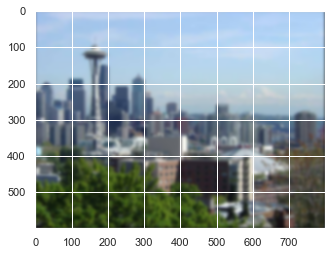

In [55]:
filtered_skimage = filters.gaussian(image_1, sigma=sigma, mode='constant', cval=0.0, multichannel=True, preserve_range=True)
plt.imshow(np.clip(filtered_skimage, 0, 255).astype(np.uint8))
plt.imsave("1.png", filtered_skimage)

In [56]:
#2 Separable Gaussian Filter
image_n = Image.open("Seattle.jpg")
image_n = np.asarray(image_n)

def convolution(oldimage, kernel):
    #image = Image.fromarray(image, 'RGB')
    image_h = oldimage.shape[0]
    image_w = oldimage.shape[1]
    
    
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    if(len(oldimage.shape) == 3):
        image_pad = np.pad(oldimage, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2, kernel_w // 2),(0,0)), mode='constant', constant_values=0).astype(np.float32)
    elif(len(oldimage.shape) == 2):
        image_pad = np.pad(oldimage, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2, kernel_w // 2)), mode='constant', constant_values=0).astype(np.float32)
    
    
    h = kernel_h // 2
    w = kernel_w // 2
    
    image_conv = np.zeros(image_pad.shape)
    
    for i in range(h, image_pad.shape[0]-h):
        for j in range(w, image_pad.shape[1]-w):
            #sum = 0
            x = image_pad[i-h:i-h+kernel_h, j-w:j-w+kernel_w]
            x = x.flatten()*kernel.flatten()
            
            
#             for m in range(kernel_h):
#                 for n in range(kernel_w):
#                     sum += kernel[m][n] * image_pad[i-h+m][j-w+n]
            
            image_conv[i][j] = x.sum()
    h_end = -h
    w_end = -w
    
    if(h == 0):
        return image_conv[h:,w:w_end]
    if(w == 0):
        return image_conv[h:h_end,w:]

    return image_conv[h:h_end,w:w_end]


def SeparableGaussian(image, sigma):
    image = imread(image)
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter_Y = np.zeros((filter_size, 1), np.float32)
    gaussian_filter_X = np.zeros((1, filter_size), np.float32)
    m = filter_size//2
    n = filter_size//2
    
    for y in range(-n, n+1):
        x1 = np.sqrt(2*np.pi*(sigma**2))
        x2 = np.exp(-(y**2)/(2* sigma**2))
        gaussian_filter_X[:, y+n] = (1/x1)*x2
    
    for x in range(-m, m):
            x1 = np.sqrt(2*np.pi*(sigma**2))
            x2 = np.exp(-(x**2)/(2* sigma**2))
            gaussian_filter_Y[x+m, :] = (1/x1)*x2
            
    #gaussian_filter = gaussian_filter_X * gaussian_filter_Y
    im_filtered = np.zeros_like(image, dtype=np.float32)
    for c in range(3):
        im_filtered[:, :, c] = convolution(image[:, :, c], gaussian_filter_X)
        
    for c in range(3):
        im_filtered[:, :, c] = convolution(im_filtered[:, :, c], gaussian_filter_Y)
    #print(gaussian_filter.sum())
    #return(plt.imshow(gaussian_filter_Y))
    return (im_filtered.astype(np.uint8))

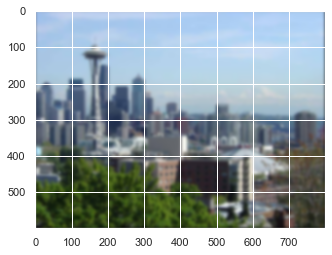

In [57]:
ima = SeparableGaussian("Seattle.jpg", 4)
plt.imshow(ima)
plt.imsave("2.png", ima)

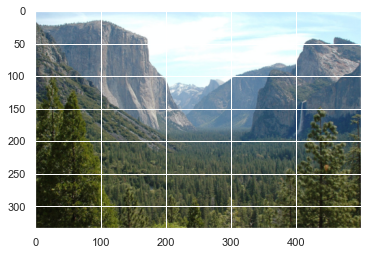

In [58]:
#3 Image Sharpening
image_2 = Image.open("Yosemite.png")
image_2 = np.asarray(image_2)
plt.imshow(image_2)

Text(0.5, 1.0, 'Sharpen')

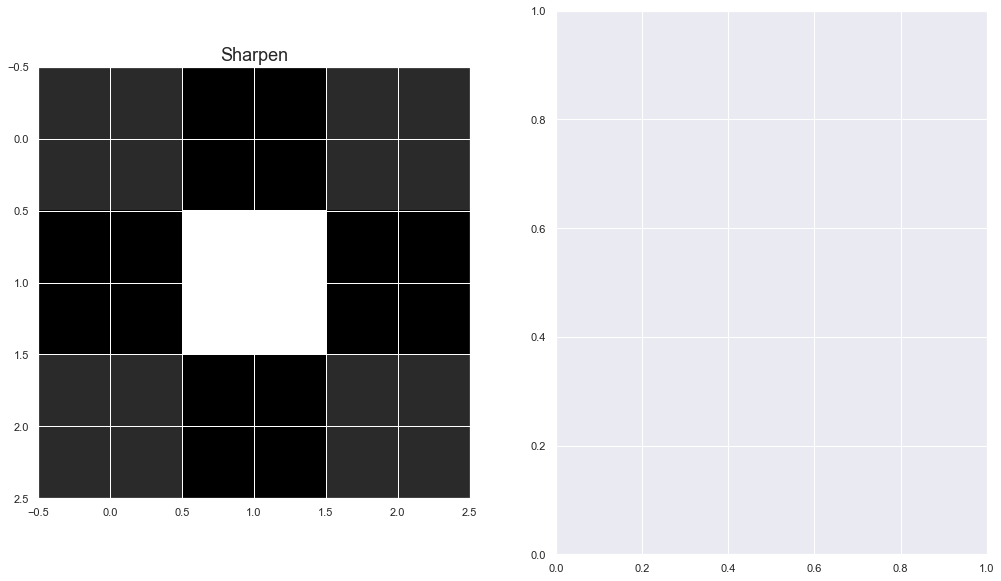

In [59]:
sharpen = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
fig, ax = plt.subplots(1,2, figsize = (17,10))
ax[0].imshow(sharpen, cmap='gray')
ax[0].set_title(f'Sharpen', fontsize = 18)

In [60]:
def multi_convolver(image, kernel, iterations):
    for i in range(iterations):
        image = convolve2d(image, kernel, 'same', boundary = 'fill',
                           fillvalue = 0)
    return image

In [61]:
def convolver_rgb(image, kernel, iterations = 1):
    convolved_image_r = multi_convolver(image[:,:,0], kernel,
                                        iterations)
    convolved_image_g = multi_convolver(image[:,:,1], kernel, 
                                        iterations)
    convolved_image_b  = multi_convolver(image[:,:,2], kernel, 
                                         iterations)
    
    reformed_image = np.dstack((np.rint(abs(convolved_image_r)), 
                                np.rint(abs(convolved_image_g)), 
                                np.rint(abs(convolved_image_b))))/255
   
                               
                     
    fig, ax = plt.subplots(1,3, figsize = (17,10))
    
    ax[0].imshow(abs(convolved_image_r), cmap='Reds')
    ax[0].set_title(f'Red', fontsize = 15)
    
    ax[1].imshow(abs(convolved_image_g), cmap='Greens')
    ax[1].set_title(f'Green', fontsize = 15)
    
    ax[2].imshow(abs(convolved_image_b), cmap='Blues')
    ax[2].set_title(f'Blue', fontsize = 15)
    
    [axi.set_axis_off() for axi in ax.ravel()]
    
    return np.array(reformed_image).astype(np.uint8)

array([[[2, 2, 2],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [2, 2, 2]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 1],
        [0, 0, 0],
        [1, 1, 2]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 2]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

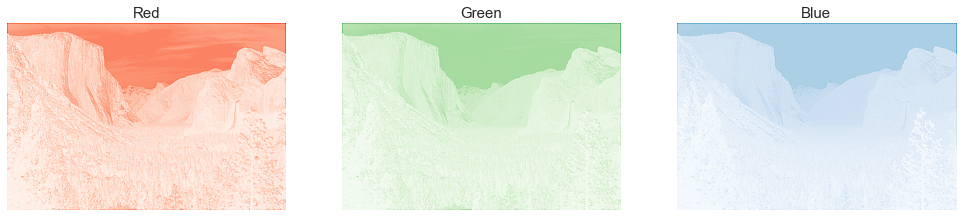

In [62]:
convolved_rgb_sharpen = convolver_rgb(image_2, sharpen, 1)
convolved_rgb_sharpen

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


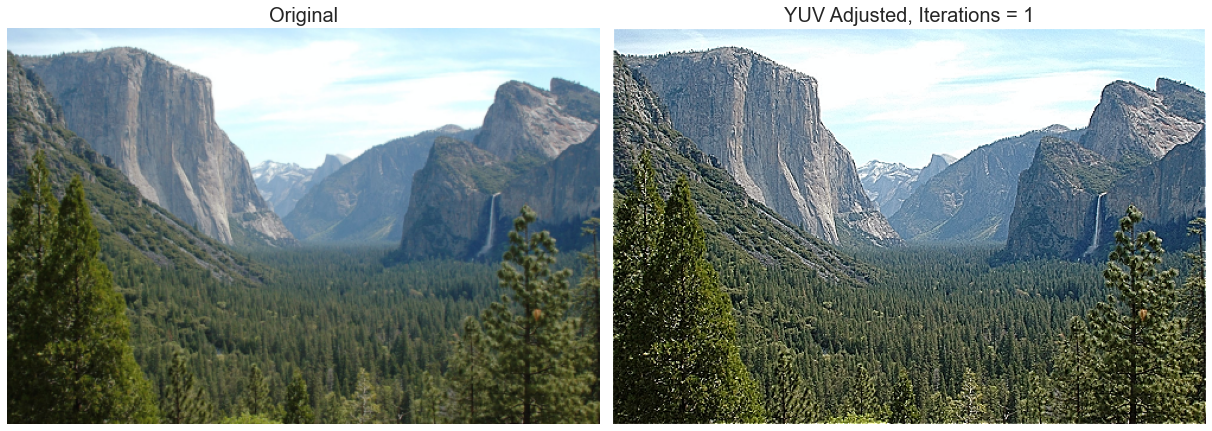

In [65]:
def convolver_rgb(image, kernel, iterations = 1):
    img_yuv = rgb2yuv(image)   
    img_yuv[:,:,0] = multi_convolver(img_yuv[:,:,0], kernel, 
                                     iterations)
    final_image = yuv2rgb(img_yuv)
                               
    fig, ax = plt.subplots(1,2, figsize = (17,10))
    
    ax[0].imshow(image)
    ax[0].set_title(f'Original', fontsize = 20)
    
    ax[1].imshow(final_image);
    ax[1].set_title(f'YUV Adjusted, Iterations = {iterations}', 
                    fontsize = 20)
    
    [axi.set_axis_off() for axi in ax.ravel()]
    
    fig.tight_layout()
    
    return final_image
final_image = convolver_rgb(image_2, sharpen, iterations = 1)
plt.imsave("4.png", final_image)

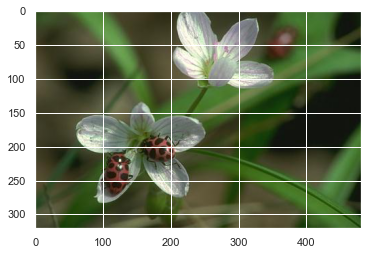

In [41]:
#4 Sobel Image
image_4 = Image.open("LadyBug.jpg")
image_4 = np.asarray(image_4)
plt.imshow(image_4)

In [44]:
def Sobel(image):
    image = Image.open(image).convert('L')
    image = np.asarray(image)
    
    im_filtered = np.zeros_like(image, dtype=np.float32)
    
    X = convolution(image, np.array([[-1,-2,-1],[0,0,0],[1,2,1]]))
    Y = convolution(image, np.array([[-1,0,1],[-2,0,2],[-1,0,1]]))
    
    magnitude = np.sqrt(X**2 + Y**2)
    
    
    orientation = np.arctan(Y , X)
    
    
    return (magnitude.astype(np.uint8), orientation.astype(np.uint8))

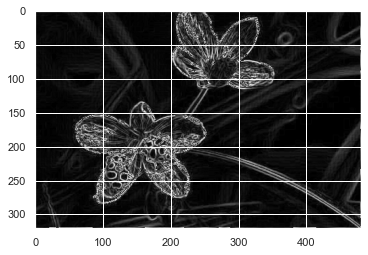

In [66]:
image_41 = Sobel("LadyBug.jpg")[0]
plt.imshow(image_41, cmap = "gray")
plt.imsave("5a.png", image_41)

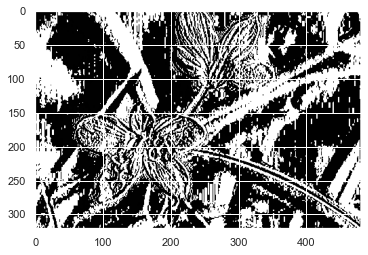

In [67]:
image_42 = Sobel("LadyBug.jpg")[1]
plt.imshow(image_42, cmap = "gray")
plt.imsave("5b.png", image_42)

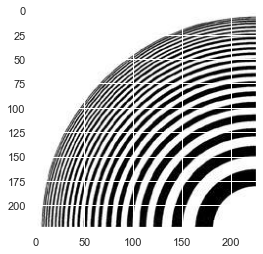

In [68]:
#5 Bilinear Interpolation
image_5 = Image.open("Moire_small.jpg")
image_5= np.asarray(image_5)
plt.imshow(image_5)

In [69]:
def interpolate_bilinear(array_in, width_in, height_in, array_out, width_out, height_out):
    for i in range(height_out):
        for j in range(width_out):
            # Relative coordinates of the pixel in output space
            x_out = j / width_out
            y_out = i / height_out

            # Corresponding absolute coordinates of the pixel in input space
            x_in = (x_out * width_in)
            y_in = (y_out * height_in)

            # Nearest neighbours coordinates in input space
            x_prev = int(np.floor(x_in))
            x_next = x_prev + 1
            y_prev = int(np.floor(y_in))
            y_next = y_prev + 1

            # Sanitize bounds - no need to check for < 0
            x_prev = min(x_prev, width_in - 1)
            x_next = min(x_next, width_in - 1)
            y_prev = min(y_prev, height_in - 1)
            y_next = min(y_next, height_in - 1)
            
            # Distances between neighbour nodes in input space
            Dy_next = y_next - y_in;
            Dy_prev = 1. - Dy_next; # because next - prev = 1
            Dx_next = x_next - x_in;
            Dx_prev = 1. - Dx_next; # because next - prev = 1
            
            # Interpolate over 3 RGB layers
            for c in range(3):
                array_out[i][j][c] = Dy_prev * (array_in[y_next][x_prev][c] * Dx_next + array_in[y_next][x_next][c] * Dx_prev) \
                + Dy_next * (array_in[y_prev][x_prev][c] * Dx_next + array_in[y_prev][x_next][c] * Dx_prev)
                
    return array_out

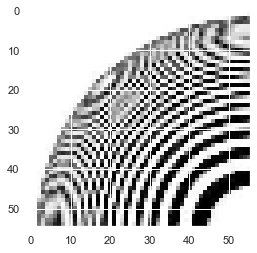

In [70]:
# load image
im = Image.open("Moire_small.jpg")
width_2 = im.width // 4
height_2 = im.height // 4

# Go to normalized float and undo gamma
# Note : sRGB gamma is not a pure power TF, but that will do
im2 = (np.array(im) / 255.)**2.4

# Interpolate in float64
out = np.zeros((height_2, width_2, 3))
out = interpolate_bilinear(im2, im.width, im.height, out, width_2, height_2)

# Redo gamma and save back in uint8
out = (out**(1/2.4) * 255.).astype(np.uint8)
#Image.fromarray(out)
plt.imshow(out)
plt.imsave("6b.png", out)

In [71]:
#Nearest Neighbor Interpolation
def nearest_neighbor(image):
    image = imread(image)
    oldImage = np.asarray(image)
    #img = Image.open(image)

    factor = 4

    W, H, C= image.shape

    newW = int(W*factor)
    newH = int(H*factor)
    newImage = np.zeros((oldImage.shape[0]*factor,oldImage.shape[1]*factor,oldImage.shape[2]), dtype=np.float32)
    #print(oldImage.shape)
    #print(newImage.shape)

    for row in range(newW):
        for col in range(newH):
            newImage[row, col] = oldImage[row//4, col//4]
            

    return (newImage.astype(np.uint8))

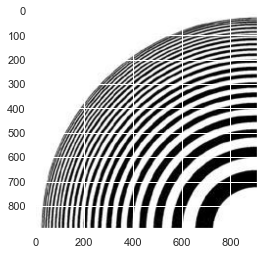

In [72]:
image_69 = nearest_neighbor("Moire_small.jpg")
plt.imshow(image_69)
plt.imsave("6a.png", image_69)

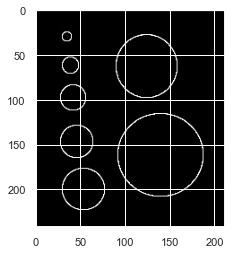

In [44]:
#6 Edge Detection
# Opening the image (R prefixed to string
# in order to deal with '\' in paths)
image_6 = Image.open(r"Circle.png")
  
# Converting the image to grayscale, as edge detection 
# requires input image to be of mode = Grayscale (L)
image_6 = image_6.convert("L")
  
# Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
image_6 = image_6.filter(ImageFilter.FIND_EDGES)
  
# Saving the Image Under the name Edge_Sample.png
image_6.save(r"7.png")
plt.imshow(image_6, cmap='gray')